In [1]:
from _element import feature_control as ft_c

In [2]:
from _usecase import algorithm_prophet as prpt

In [3]:
from _element import calculations as calc

In [4]:
import pandas as pd

In [5]:
from datetime import datetime

In [6]:
from _element import varr

In [7]:
INPUT_FILENAME= 'KPP일별투입(10_17)_raw.xlsx'

In [8]:
df_raw= ft_c.xlsx_opener(varr.PJ_DIR+varr.DF_DIR, INPUT_FILENAME)

In [9]:
df_temp= ft_c.xlsx_opener(varr.PJ_DIR+varr.TEMP_DATA_DIR, 'temp_data_merged.xlsx')

In [10]:
y_col= df_raw.columns.values.tolist()

In [11]:
try:
    y_col.remove('ds')
except ValueError:
    pass

In [12]:
y_col

['y']

In [13]:
x_col= df_temp.columns.values.tolist()

In [14]:
x_col

['ds', 'temp_max', 'temp_min', 'rain_amount']

In [15]:
df_raw['ds']= pd.to_datetime(df_raw['ds'], box=True, format= '%Y/%m/%d', exact=True)

In [16]:
df_temp['ds']= pd.to_datetime(df_temp['ds'], box=True, format= '%Y/%m/%d', exact=True)

In [17]:
df_raw= pd.merge(df_raw, df_temp, how='inner', on='ds')

In [18]:
df_raw.head()

,ds,y,temp_max,temp_min,rain_amount
0,2010-07-01,79590,30.500000,24.900000,0.0
1,2010-07-02,79456,25.799999,22.700001,70.0
2,2010-07-03,48469,25.600000,22.600000,1.0
3,2010-07-04,1045,29.700001,23.100000,0.0
4,2010-07-05,65049,30.600000,21.799999,0.0


In [19]:
df_weekday_0= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==0]
df_weekday_1= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==1]
df_weekday_2= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==2]
df_weekday_3= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==3]
df_weekday_4= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==4]
df_weekday_5= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==5]
df_weekday_6= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==6]

In [20]:
result_dict= {}
for y in y_col:
    result_dict[y]= {
                    'mon': prpt.Bayseian2(df_weekday_0, varr.FORECASTDAY, y, x_col, 'week'),\
                    'tue': prpt.Bayseian2(df_weekday_1, varr.FORECASTDAY, y, x_col, 'week'),\
                    'wed': prpt.Bayseian2(df_weekday_2, varr.FORECASTDAY, y, x_col, 'week'),\
                    'thu': prpt.Bayseian2(df_weekday_3, varr.FORECASTDAY, y, x_col, 'week'),\
                    'pri': prpt.Bayseian2(df_weekday_4, varr.FORECASTDAY, y, x_col, 'week'),\
                    'sat': prpt.Bayseian2(df_weekday_5, varr.FORECASTDAY, y, x_col, 'week'),\
                    'sun': prpt.Bayseian2(df_weekday_6, varr.FORECASTDAY, y, x_col, 'week'),\
                    }

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [21]:
merged_dict={}
for y in y_col:
    merged_dict[y]={'future': 
                    pd.concat([result_dict[y]['mon']['future'],\
                              result_dict[y]['tue']['future'],\
                              result_dict[y]['wed']['future'],\
                              result_dict[y]['thu']['future'],\
                              result_dict[y]['pri']['future'],\
                              result_dict[y]['sat']['future'],\
                              result_dict[y]['sun']['future']],\
                              axis= 0).sort_values(by='ds', axis=0),
                   'forecastProphetTable':
                    pd.concat([result_dict[y]['mon']['forecastProphetTable'],\
                              result_dict[y]['tue']['forecastProphetTable'],\
                              result_dict[y]['wed']['forecastProphetTable'],\
                              result_dict[y]['thu']['forecastProphetTable'],\
                              result_dict[y]['pri']['forecastProphetTable'],\
                              result_dict[y]['sat']['forecastProphetTable'],\
                              result_dict[y]['sun']['forecastProphetTable']],\
                              axis= 0).sort_values(by='ds', axis=0)
                   }

In [22]:
forecast_dict={}
print(INPUT_FILENAME)
for y in y_col:
    merged_dict[y]['future']['ds']= pd.to_datetime(merged_dict[y]['future']['ds'], box=True, format= '%Y/%m/%d', exact=True)
    merged_dict[y]['forecastProphetTable']['ds']= pd.to_datetime(merged_dict[y]['forecastProphetTable']['ds'], box=True, format= '%Y/%m/%d', exact=True)
    forecast_dict[y]= prpt.extract_info_from(merged_dict[y]['future'], merged_dict[y]['forecastProphetTable'], varr.FORECASTDAY)
    forecast_dict[y]['result_df']= pd.merge(forecast_dict[y]['result_df'], df_raw[['ds', y]], how='inner', on='ds')
    print('RMSE with segment '+str(y)+': '+str(calc.rms_error(forecast_dict[y]['result_df'][y], forecast_dict[y]['result_df']['yhat'])))
    print('MAPE with segment '+str(y)+': '+str(calc.map_error(forecast_dict[y]['result_df'][y], forecast_dict[y]['result_df']['yhat'])))
    print('MAPE_with_std with segment '+str(y)+': '+str(calc.map_error_with_std(forecast_dict[y]['result_df'][y], forecast_dict[y]['result_df']['yhat'])))
    print('MAPE_div_std with segment '+str(y)+': '+str(calc.map_error_div_std(forecast_dict[y]['result_df'][y], forecast_dict[y]['result_df']['yhat'])))
    print('sMAPE of company code '+str(y)+': '+str(calc.smap_error(forecast_dict[y]['result_df'][y], forecast_dict[y]['result_df']['yhat'])))
    print(forecast_dict[y]['result_df'].head())
    ft_c.save_as_xlsx(varr.PJ_DIR+varr.DF_DIR, forecast_dict[y]['result_df'], INPUT_FILENAME, '_seg'+str(y)+'withweekday')
    print('\n')

KPP일별투입(10_17)_raw.xlsx
RMSE with segment y: 5817.0368381
MAPE with segment y: 31.8372427929
MAPE_with_std with segment y: 18.9839273145
MAPE_div_std with segment y: 69.4070373124
sMAPE of company code y: 2.05157476776
          ds   temp_max  temp_min  rain_amount           yhat       y
0 2017-11-01  17.299999      13.4          0.0  127091.228433  127688
1 2017-11-02  18.000000      14.0          1.6  122035.919376  132155
2 2017-11-03  15.700000       4.5          0.6  121916.422273  133493
3 2017-11-04  12.800000       3.2          0.0   64829.198817   65514
4 2017-11-05  14.200000       7.3          0.0      58.010722     105




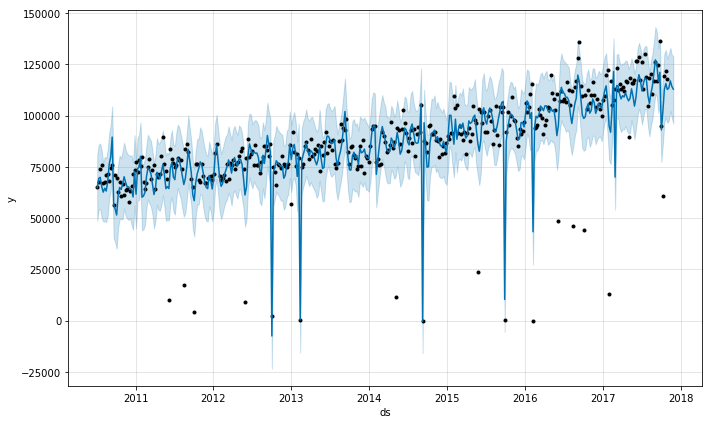

In [25]:
result_dict['y']['mon']['model'].plot(result_dict['y']['mon']['forecastProphetTable'])

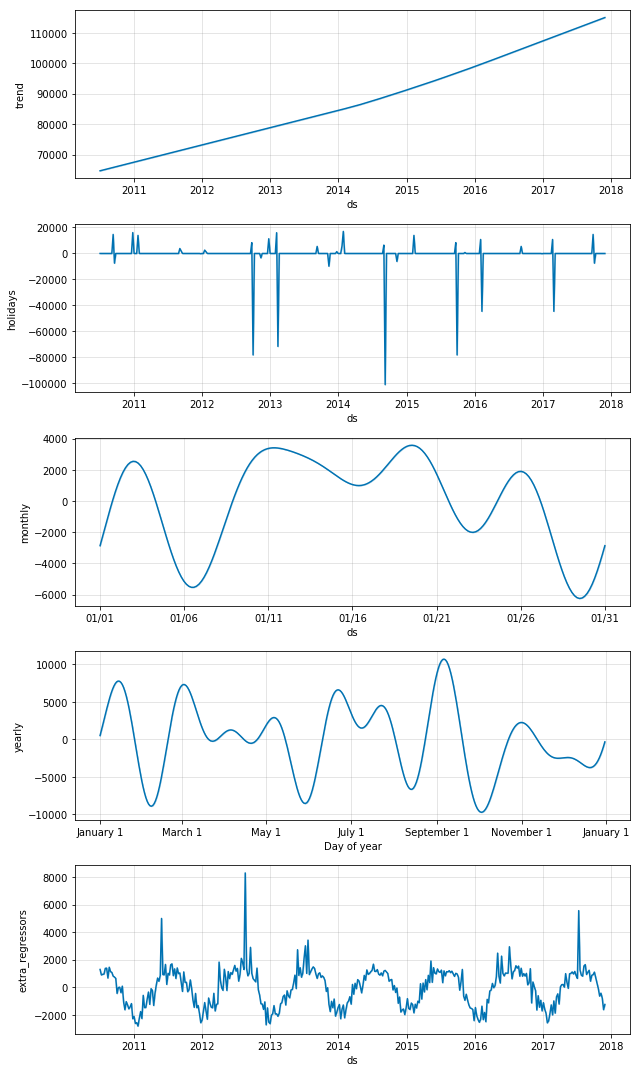

In [39]:
result_dict['y']['mon']['model'].plot_components(result_dict['y']['mon']['forecastProphetTable'])

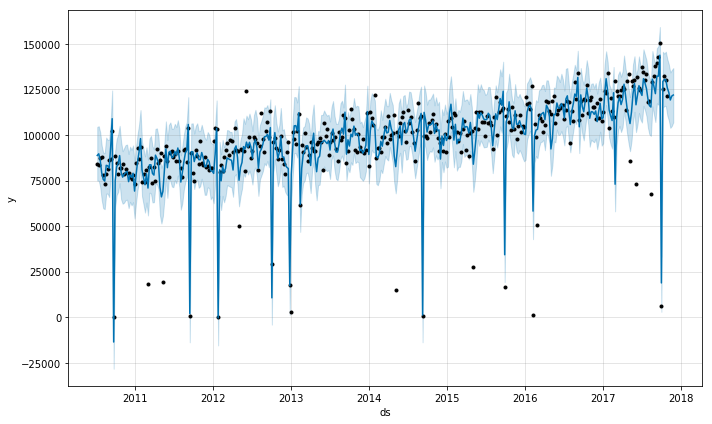

In [27]:
result_dict['y']['tue']['model'].plot(result_dict['y']['tue']['forecastProphetTable'])

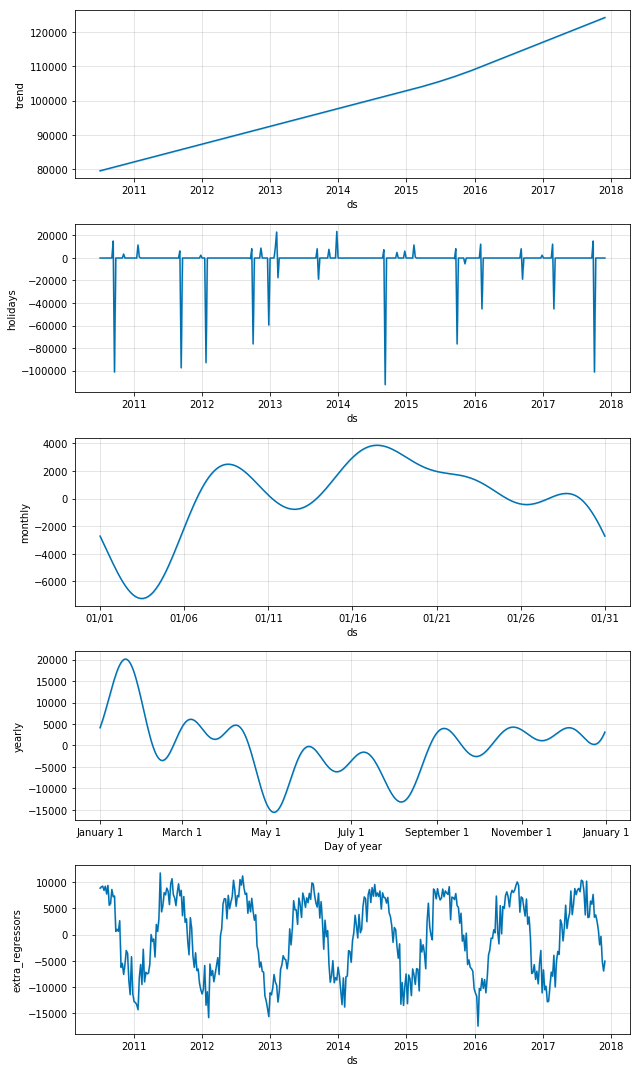

In [28]:
result_dict['y']['tue']['model'].plot_components(result_dict['y']['tue']['forecastProphetTable'])

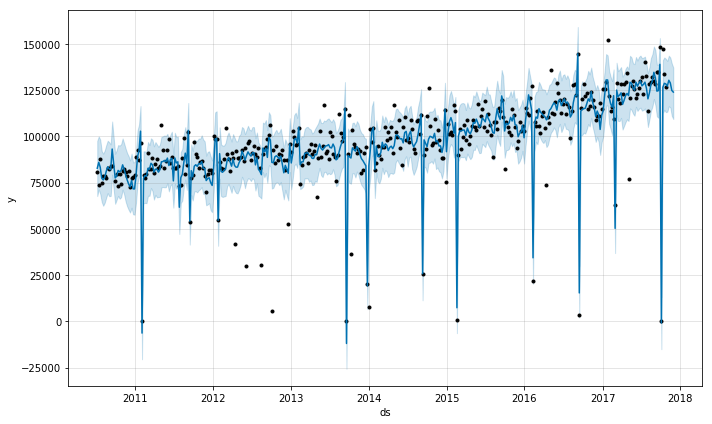

In [29]:
result_dict['y']['wed']['model'].plot(result_dict['y']['wed']['forecastProphetTable'])

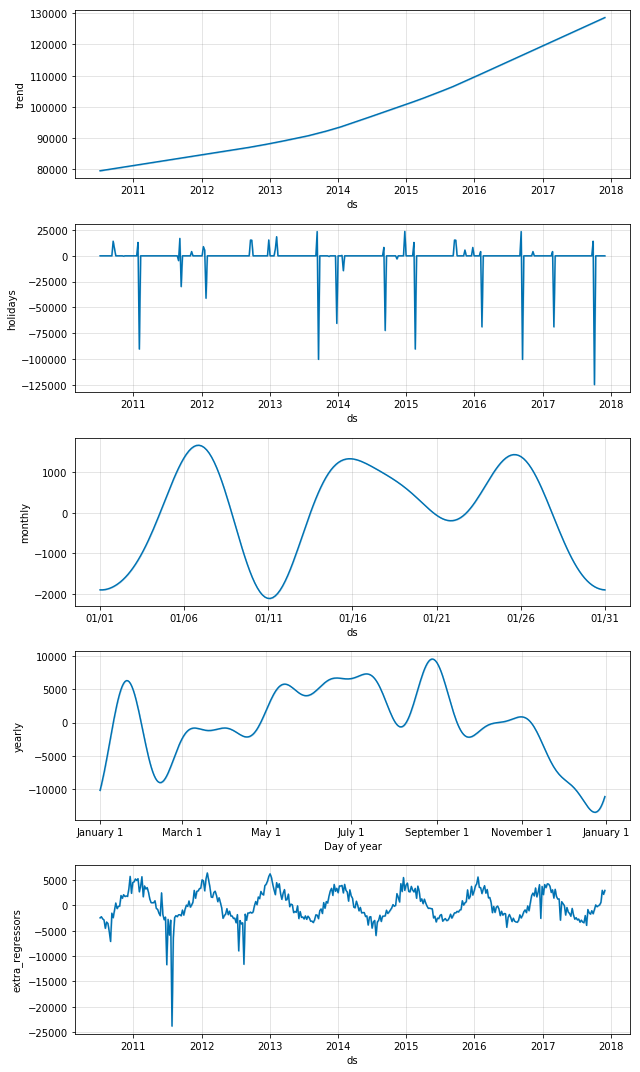

In [30]:
result_dict['y']['wed']['model'].plot_components(result_dict['y']['wed']['forecastProphetTable'])

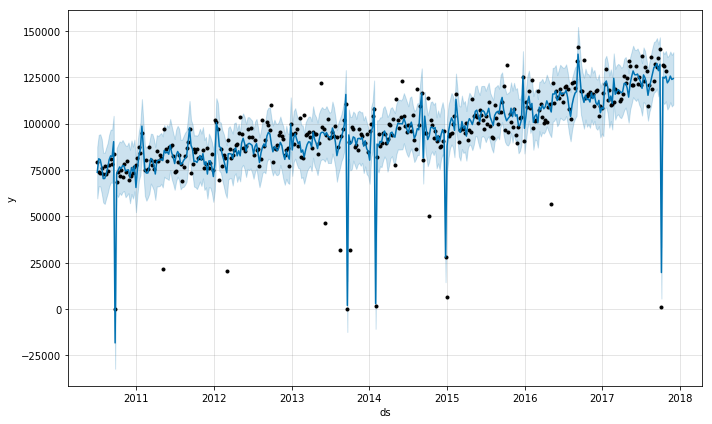

In [31]:
result_dict['y']['thu']['model'].plot(result_dict['y']['thu']['forecastProphetTable'])

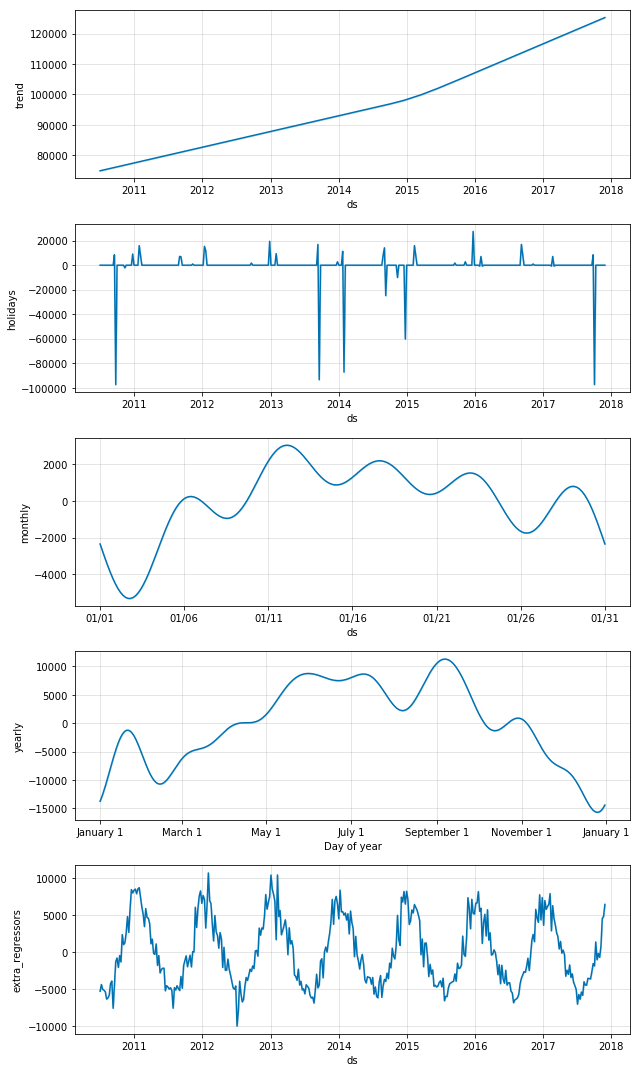

In [32]:
result_dict['y']['thu']['model'].plot_components(result_dict['y']['thu']['forecastProphetTable'])

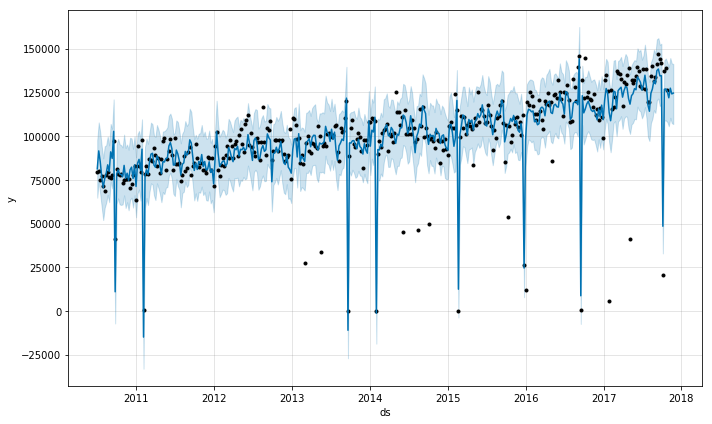

In [33]:
result_dict['y']['pri']['model'].plot(result_dict['y']['pri']['forecastProphetTable'])

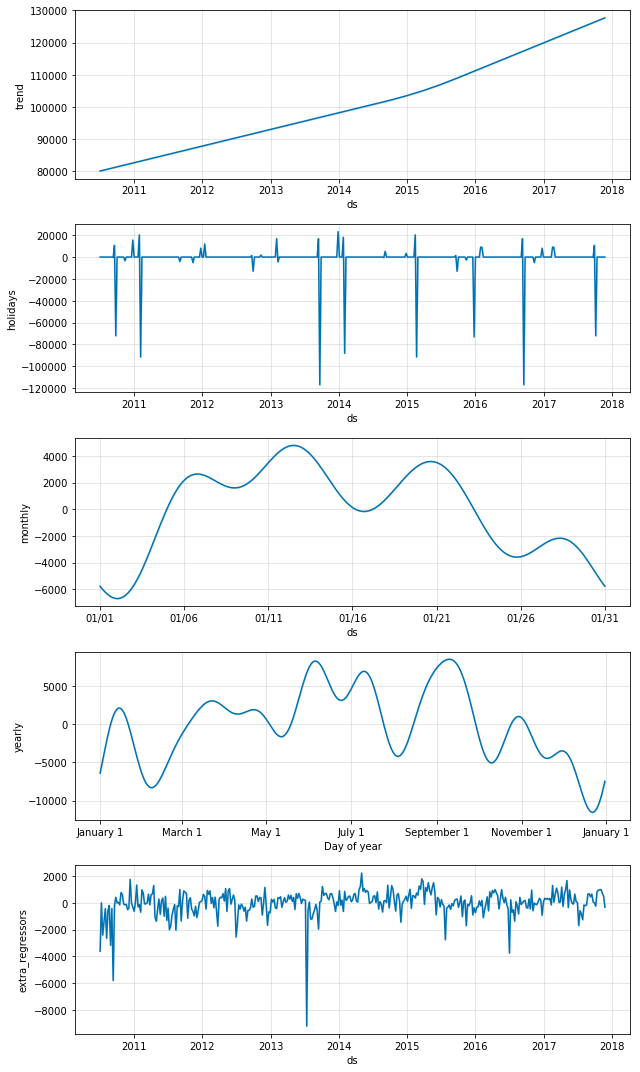

In [34]:
result_dict['y']['pri']['model'].plot_components(result_dict['y']['pri']['forecastProphetTable'])

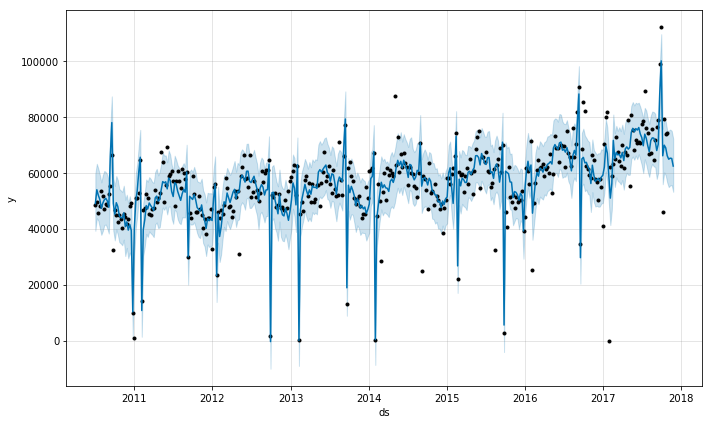

In [35]:
result_dict['y']['sat']['model'].plot(result_dict['y']['sat']['forecastProphetTable'])

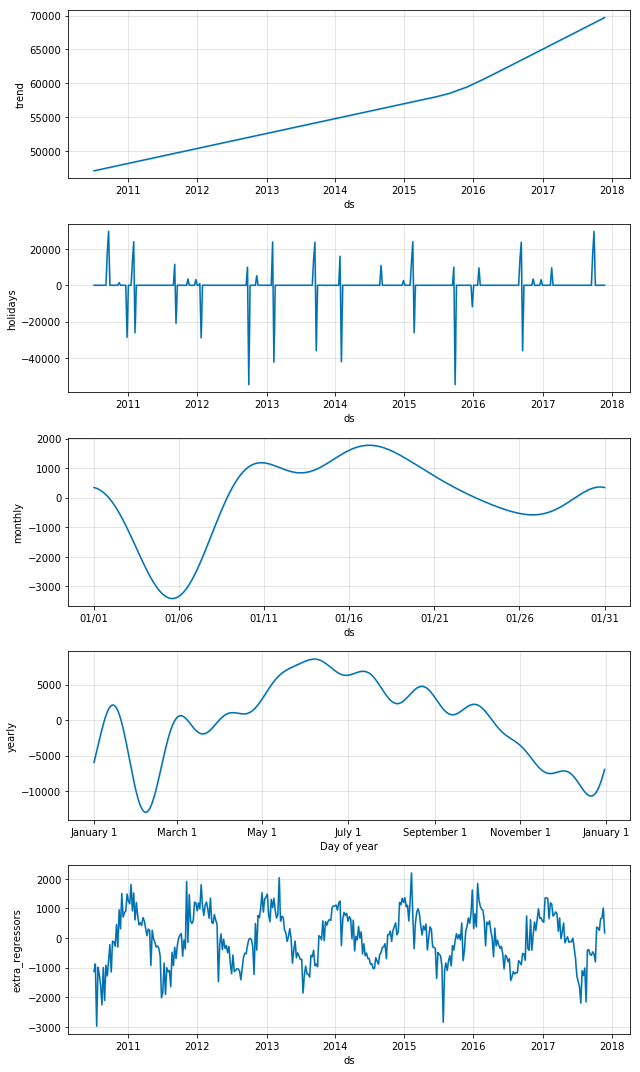

In [36]:
result_dict['y']['sat']['model'].plot_components(result_dict['y']['sat']['forecastProphetTable'])

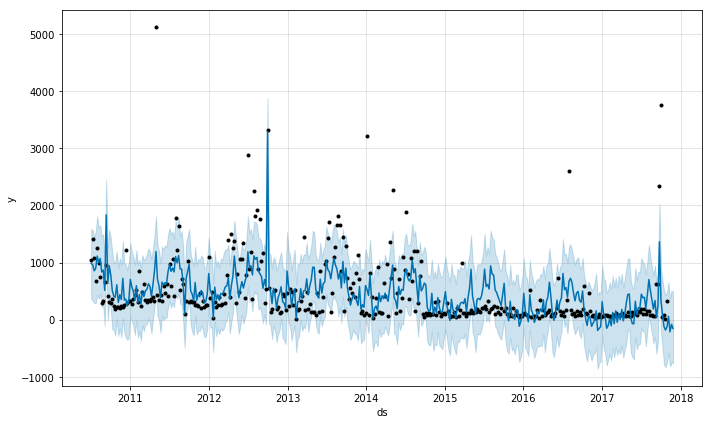

In [37]:
result_dict['y']['sun']['model'].plot(result_dict['y']['sun']['forecastProphetTable'])

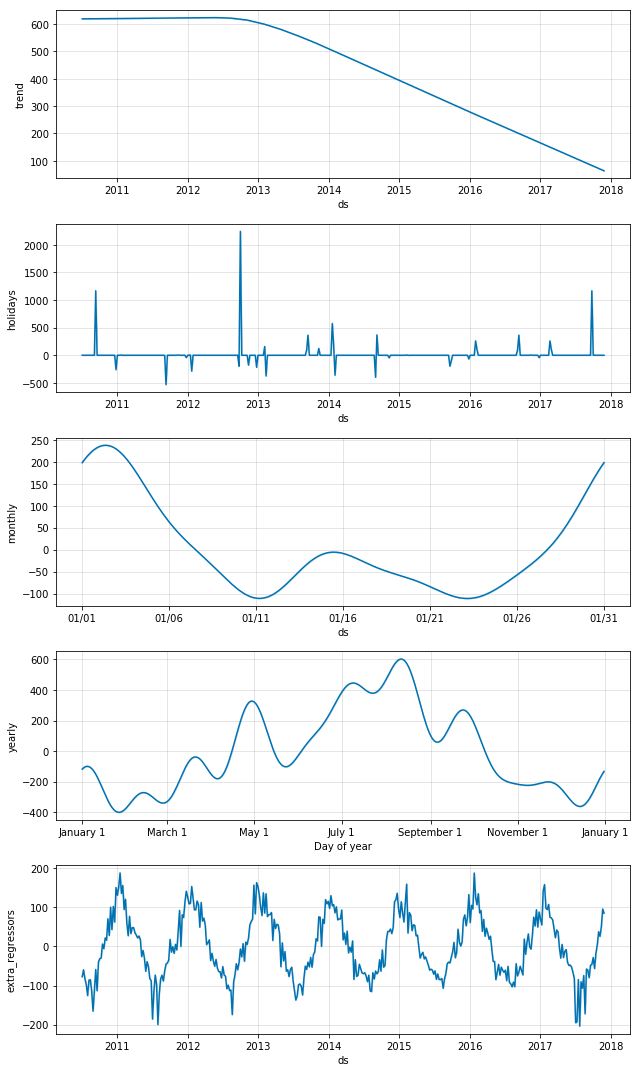

In [38]:
result_dict['y']['sun']['model'].plot_components(result_dict['y']['sun']['forecastProphetTable'])